In [1]:
import src.generation.gamma as ga
import src.generation.multivariate_normal as mn

from src.salp.salp import SALP
from src.salp.salp import Node

from src.algorithms.round_robin import RoundRobin
from src.algorithms.best_fit import BestFit

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# funkcja do produkowania wykresów obciążenia węzłów

def plot_node_load(n: Node, estimated_node_load: float = None, actual_mean_node_load: float = None, node_power: float = None):
    size = n.ws.size
    plt.bar(
        np.arange(size),
        n.ws
    )
    plt.title("Node {}".format(n.identity))
    if estimated_node_load:
        plt.hlines(estimated_node_load, xmin=0-1, xmax=size, colors='r')
    if actual_mean_node_load:
        plt.hlines(actual_mean_node_load, xmin=0-1, xmax=size, colors='g', linestyle='dashed')
    if node_power:
        plt.hlines(node_power, xmin=0-1, xmax=size, colors='orange')
    plt.show()

# SALP

----------------DESCRIPTION----------------
Shards:
[[3 1]
 [3 1]
 [3 1]
 [1 3]
 [1 3]
 [1 3]]

WTS:
[12 12]

NWTS:
[6. 6.]

LW:
[(0, 3.1622776601683795), (1, 3.1622776601683795), (2, 3.1622776601683795), (3, 3.1622776601683795), (4, 3.1622776601683795), (5, 3.1622776601683795)]


----------------ASSIGNMENT----------------
Shard ID: 0
Shard: [3 1]

	Node ID: 0
	Delta: 2.654329479393269

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 1
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 2
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 1.8309518948453007

Shard ID: 3
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 3.0025247700991105

Shard ID: 4
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 1.4142135623730951

Shard ID: 5
Shard: [1 3]

	Node ID: 1
	Delta: 1.4142135623730951

----------------FINAL NODES----------------
Node: 0
	Shards assigned [FS]: [0 2 4]
	

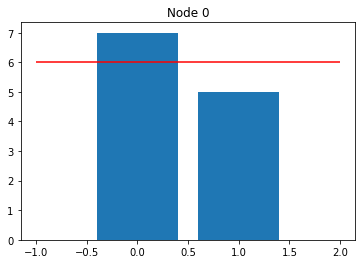

Node 1: 1.0


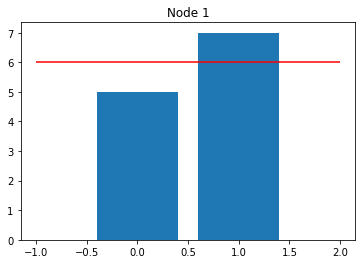

In [3]:
N = 2 # try with n=3 <3
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
cloud = SALP(N,instance, True)
load = np.sum(instance)
mean_node_load = load/N/size

for n in cloud.nodes:
    # stabilność
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

# RR

Shard 0 [3 1] to Node 0 node lw [3. 1.]
Shard 1 [3 1] to Node 1 node lw [3. 1.]
Shard 2 [3 1] to Node 0 node lw [6. 2.]
Shard 3 [1 3] to Node 1 node lw [4. 4.]
Shard 4 [1 3] to Node 0 node lw [7. 5.]
Shard 5 [1 3] to Node 1 node lw [5. 7.]
Node 0: 1.0


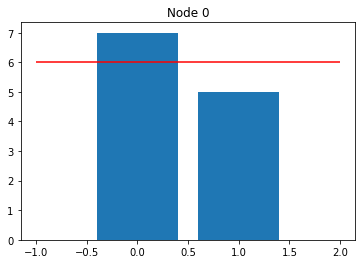

Node 1: 1.0


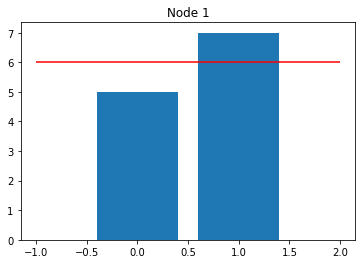

In [4]:
N = 2 # try with n=3 <3
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
cloud = RoundRobin(N,instance, True)
load = np.sum(instance)
mean_node_load = load/N/size

for n in cloud.nodes:
    # stabilność
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

# Best Fit

Node 1 - assigned shards: [4, 0, 2]
Node 0 - assigned shards: [5, 1, 3]
Node 0: 1.125


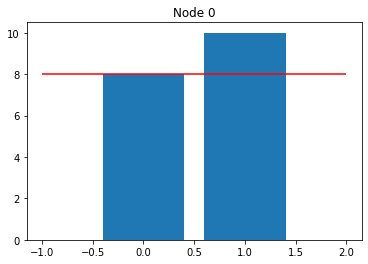

Node 1: 0.875


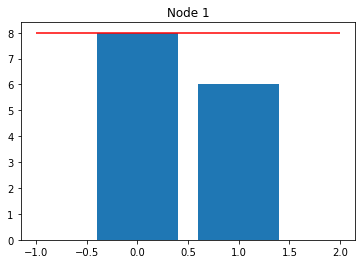

In [12]:
N = 2
size = 2
instance = np.array([[3,1],[4,2],[3,1],[1,3],[2,4],[3,5]])
cloud = BestFit(N,instance, True, False)
cloud.assign()
load = np.sum(instance)
mean_node_load = load/N/size

for n in cloud.nodes:
    # stabilność
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

8.0
[(5, 4.0), (1, 3.0), (4, 3.0), (0, 2.0), (2, 2.0), (3, 2.0)]
Error, all nodes should be assigned
Node 0: 0.875


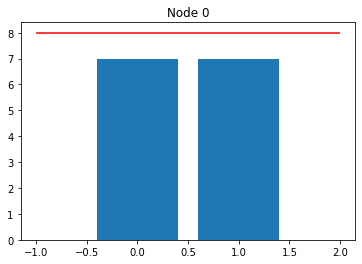

Node 1: 0.875


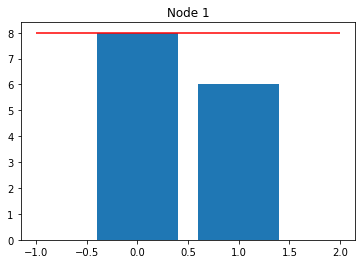

In [11]:
def best_fit2(n: int, shards: np.ndarray):
    
    node_mean_load = np.sum(shards) / n / shards.shape[1]
    print(node_mean_load)
    
    nodes = [Node(e) for e in range(0, n)]
    ss = [(i, v) for i, v in enumerate(np.mean(shards, axis=1)) ]
    ss.sort(key=lambda x: x[1], reverse=True)
    usd = [False for _ in range(len(ss))]
    print(ss)
    
    tolerance = node_mean_load * 0.1 # zakładamy, ze node może zostać przepełniony o 10%
    for node in nodes:
        for i, m in ss:
            if usd[i]:
                continue
            nl = np.mean(node.ws)
            if nl + m < node_mean_load + tolerance:
                node.shard_append(i, shards[i])
                usd[i] = True
            if all(usd):
                print("all asigned")
                break
    if not all(usd):
        print("Error, all nodes should be assigned")
        # TODO assign remaining nodes with first fit
    return nodes

N = 2
size = 2
instance = np.array([[3,1],[4,2],[3,1],[1,3],[2,4],[3,5]])
load=np.sum(instance)
mean_node_load = load/N/size
nds = best_fit2(N, instance)

for n in nds:
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)